# **Classifying buildings Post Hurricane using Satellite Imagery**

The latest hurricane - Hurricane Iota, had 61 total fatalities, and 41 are still missing. After a hurricane, damage assessment is vital to the relief helpers and first responders so that resources and help can be planned and allocated appropriately. One way to measure the damage is to detect and quantify the number of damaged buildings, usually done by driving around the affected area and noting down manually. This process can be labor-intensive and time-consuming and not the most efficient method as well. Hence in this project, our objective is to classify buildings between **damaged** and **not damaged** buildings using the satellite imagery data.

Following is the broader description of the work carried out in this notebook:

1. **Data Pre-Processing and EDA:** Accessing images for visualising the damaged and undamaged images by creating directories using paths, and performing necessary operations in data agumentation to make images ready for model training.

2. **Building a Base model:** Constructing a CNN network and extracting inferences for both balanced and unbalanced test sets.

3. **Activation maps, Saliency maps, GradCam :** Visualising which part of the model is most important for training the model.

4. **Comparing Base model results:** Building other models like Regularised model or implementing SOTA models to compare the results of base model 

**Importing all the necessary libraries**

In [1]:
!pip install tf_keras_vis

In [2]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow
from tensorflow.keras import Sequential,Model
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten,BatchNormalization,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory


from tf_keras_vis.saliency import Saliency
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import BinaryScore
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from matplotlib import cm


from PIL import Image
from pathlib import Path


import os

# Loading the data

Firstly , we will be making seperate directories to import the images with labels

In [3]:
#directories for train, validation and test images
train_directory = Path('/kaggle/input/posthurricane/train_another') # the training data; 5000 images of each class(damage/no damage)
validation_directory = Path('/kaggle/input/posthurricane/validation_another') #the validation data; 1000 images of each class(damage/no damage)
unbalanced_test_directory = Path('/kaggle/input/posthurricane/test_another') # 8000/1000 images of damaged/undamaged classes
balanced_test_directory = Path('/kaggle/input/posthurricane/test') # the balanced test data; 1000 images of each class(damage/no damage)

**train_another** named dataset has two subfolders named **damage** and **no_damage**.
We will be storing the labels and the images separately in two lists for further operations

In [4]:
#Inialising empty lists for storing both of the damage and no_damage folders
labels_train,images_train,labels_test_another,images_test_another,labels_test,images_test = [],[],[],[],[],[]

for i in ['damage','no_damage']: 
    files_train = os.listdir(f'/kaggle/input/posthurricane/train_another/{i}')
    files_test_another =  os.listdir(f'/kaggle/input/posthurricane/test_another/{i}')
    files_test =  os.listdir(f'/kaggle/input/posthurricane/test/{i}')
    images_train.append(files_train)
    images_test_another.append(files_test_another)
    images_test.append(files_test)

    for l in range(len(files_train)):
        labels_train.append(i)
    for l in range(len(files_test_another)):
        labels_test_another.append(i)
    for l in range(len(files_test)):
        labels_test.append(i)
    
print("Number of items in the training set : {}".format(len(labels_train)))
    
print("Number of items in the test_another dataset : {}".format(len(labels_test_another)))
    
print("Number of items in the test dataset : {}".format(len(labels_test)))

Number of items in the training set : 10000
Number of items in the test_another dataset : 9000
Number of items in the test dataset : 2000


In [5]:
#Checking the data in labels list for each dataset

print(labels_train[:5]); print(labels_test[:5]) ; print(labels_test_another[:5])
print(labels_train[-5:]); print(labels_test[-5:]) ; print(labels_test_another[-5:])

['damage', 'damage', 'damage', 'damage', 'damage']
['damage', 'damage', 'damage', 'damage', 'damage']
['damage', 'damage', 'damage', 'damage', 'damage']
['no_damage', 'no_damage', 'no_damage', 'no_damage', 'no_damage']
['no_damage', 'no_damage', 'no_damage', 'no_damage', 'no_damage']
['no_damage', 'no_damage', 'no_damage', 'no_damage', 'no_damage']


We can see that the labels list of each dataset contain values as either ***'damage' or 'no_damage'*** in it.

Let's visualise the number of labels present of each class for the Train,Unbalanced Test & Balanced Test datasets by a countplot

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


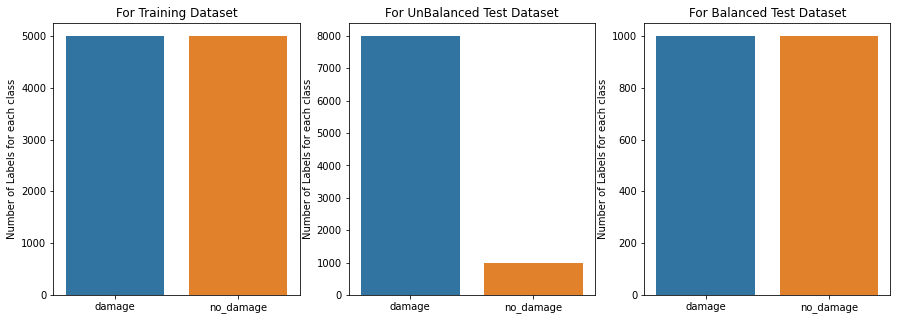

In [6]:
#visualising the number of labels present of each class for each dataset

fig,ax = plt.subplots(1,3,figsize = (15,5))

classes = ['damage','no_damage']

sns.countplot(labels_train,ax = ax[0])
ax[0].set_title('For Training Dataset')
ax[0].set_xticklabels(classes)
ax[0].set_ylabel('Number of Labels for each class')

sns.countplot(labels_test_another,ax = ax[1])
ax[1].set_title('For UnBalanced Test Dataset')
ax[1].set_ylabel('Number of Labels for each class')
ax[1].set_xticklabels(classes)

sns.countplot(labels_test,ax = ax[2])
ax[2].set_title('For Balanced Test Dataset')
ax[2].set_ylabel('Number of Labels for each class')
ax[2].set_xticklabels(classes)

plt.show()

Now, Let's see how the ***damaged and undamaged*** images looks like..!

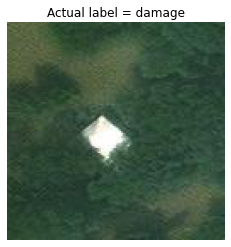

In [7]:
#damaged image display with PIL
img1 = Image.open('/kaggle/input/posthurricane/train_another/damage/-93.55964_30.895018.jpeg') #train_damaged
plt.imshow(img1)
plt.title(f'Actual label = {labels_train[0]}')
plt.axis('off')
plt.show()

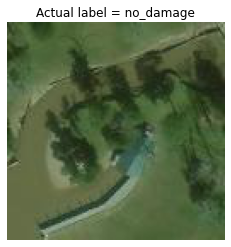

In [8]:
#undamaged image display with PIL
img2 = Image.open('/kaggle/input/posthurricane/train_another/no_damage/-95.061275_29.831535.jpeg') #train_undamaged
plt.imshow(img2)
plt.title(f'Actual label = {labels_train[5000]}')
plt.axis('off')
plt.show()

Let's explore more by **visualising the image with RGB channels seperately**

Our NumPy array has the shape: (128, 128, 3)


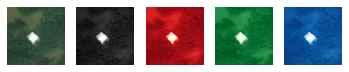

In [9]:
# Turn our image object into a NumPy array
img_data = np.array(img1)

# get the shape of the resulting array
img_data_shape = img_data.shape

print("Our NumPy array has the shape: {}".format(img_data_shape))

# plot the data with `imshow` 
fig,ax = plt.subplots(1,5)

ax[0].imshow(img_data)
ax[0].axis('off')
# grayscale image
ax[1].imshow(img_data[:,:,2], cmap='gray')
ax[1].axis('off')
# plot the red channel
ax[2].imshow(img_data[:,:,0], cmap=plt.cm.Reds_r)
ax[2].axis('off')
# plot the green channel
ax[3].imshow(img_data[:,:,1], cmap=plt.cm.Greens_r)
ax[3].axis('off')

# plot the blue channel
ax[4].imshow(img_data[:,:,2], cmap=plt.cm.Blues_r)
ax[4].axis('off')

plt.show()

# Preprocessing the data

Let's Generate batches of tensor image data with real-time data augmentation by using **ImageDataGenerator**

In [10]:
#using image data generator to get different versions of each image to make them ready for training better

train_gen = ImageDataGenerator(rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        rescale=1/255, #re-scaling
        brightness_range=[0.2,1.2]) # brightness)

validation_gen = ImageDataGenerator(rescale=1/255) #re-scaling

test_unbalanced_gen =  ImageDataGenerator(rescale=1/255) #re-scaling

test_balanced_gen =  ImageDataGenerator(rescale=1/255) #re-scaling

Now, we make individual augmented datasets for each directory using **flow_from_directory** which takes the path to a directory & generates batches of augmented data.

In [11]:
#Creating Augmented Datasets for each directory

train_data = train_gen.flow_from_directory(
    directory = train_directory,
    target_size = (128,128), #as the test images have size of (128,128)
    class_mode = 'binary', #as it's a binary classification problem  
    shuffle = True,
    batch_size=64)

val_data = validation_gen.flow_from_directory(
    directory = validation_directory,
    target_size = (128,128),
    class_mode = 'binary',
    shuffle = True,
    batch_size=64)

unbalanced_data = test_unbalanced_gen.flow_from_directory(
    directory =unbalanced_test_directory,
    target_size = (128,128),
    class_mode = 'binary',
    shuffle = True,
    batch_size=64)

balanced_data = test_balanced_gen.flow_from_directory(
    directory = balanced_test_directory,
    target_size = (128,128),
    class_mode = 'binary',
    shuffle = True,
    batch_size=64)

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


# **Base Model**

1. Building a model with below architecture of convolutional layers,max pooling layers, dense layers and output layer
2. Pass the Train Augmented Dataset into the model with input shape = (128,128,3) as Input

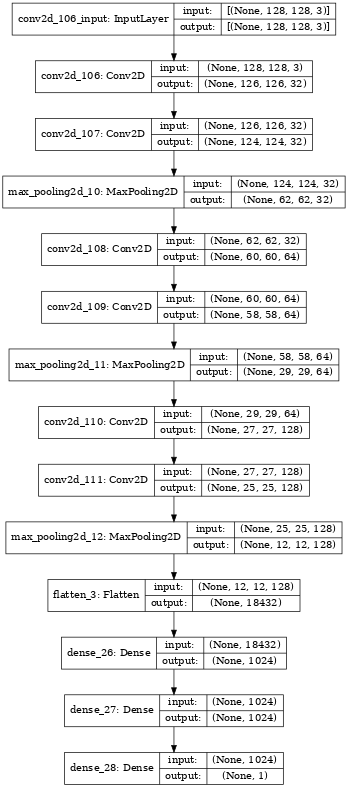

In [77]:
# Initialize a sequential model
model = Sequential(name="Base_Model")

#Convolutional layers with 32 filters with relu activation and kernel size as 3
model.add(Conv2D(32,kernel_size =(3, 3), activation='relu',input_shape=(128,128,3)))
model.add(Conv2D(32,kernel_size =(3,3), activation='relu'))

#MaxPooling layer with pool size 2
model.add(MaxPool2D(pool_size=(2, 2)))

#Convolutional layers with 64 filters with relu activation and kernel size as 3
model.add(Conv2D(64,kernel_size =(3,3), activation='relu'))
model.add(Conv2D(64,kernel_size =(3,3), activation='relu'))

#MaxPooling layer with pool size 2
model.add(MaxPool2D(pool_size=(2, 2)))

#Convolutional layers with 128 filters with relu activation and kernel size as 3
model.add(Conv2D(128,kernel_size =(3,3), activation='relu'))
model.add(Conv2D(128,kernel_size =(3,3), activation='relu'))

#MaxPooling layer with pool size 2
model.add(MaxPool2D(pool_size=(2, 2)))

#Flatten layer
model.add(Flatten())

#Two Dense layers with 1024 neurons each with relu activation
model.add(Dense(1024,activation='relu'))
model.add(Dense(1024,activation='relu'))

#Output layer with 1 neuron and with sigmoid activation as it's a binary classification problem
model.add(Dense(1,activation = 'sigmoid'))

#plot_model
tensorflow.keras.utils.plot_model(model, "base_model.png", show_shapes=True,dpi =50)

In [78]:
# Compiling the model with loss function as binary_crossentropy & optimizer as adam

model.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [79]:
#training the model using .fit()

history_1 = model.fit(train_data,validation_data=val_data,epochs=10)

Epoch 1/10
157/157 [==============================] - 68s 428ms/step - loss: 0.5468 - accuracy: 0.7262 - val_loss: 0.4360 - val_accuracy: 0.8200
Epoch 2/10
157/157 [==============================] - 62s 393ms/step - loss: 0.3519 - accuracy: 0.8613 - val_loss: 0.5193 - val_accuracy: 0.7435
Epoch 3/10
157/157 [==============================] - 68s 432ms/step - loss: 0.2673 - accuracy: 0.8981 - val_loss: 0.2327 - val_accuracy: 0.9110
Epoch 4/10
157/157 [==============================] - 63s 398ms/step - loss: 0.2319 - accuracy: 0.9060 - val_loss: 0.2220 - val_accuracy: 0.9110
Epoch 5/10
157/157 [==============================] - 64s 405ms/step - loss: 0.1976 - accuracy: 0.9178 - val_loss: 0.2740 - val_accuracy: 0.8870
Epoch 6/10
157/157 [==============================] - 63s 400ms/step - loss: 0.1960 - accuracy: 0.9215 - val_loss: 0.2384 - val_accuracy: 0.9020
Epoch 7/10
157/157 [==============================] - 60s 384ms/step - loss: 0.1794 - accuracy: 0.9268 - val_loss: 0.1984 - val_ac

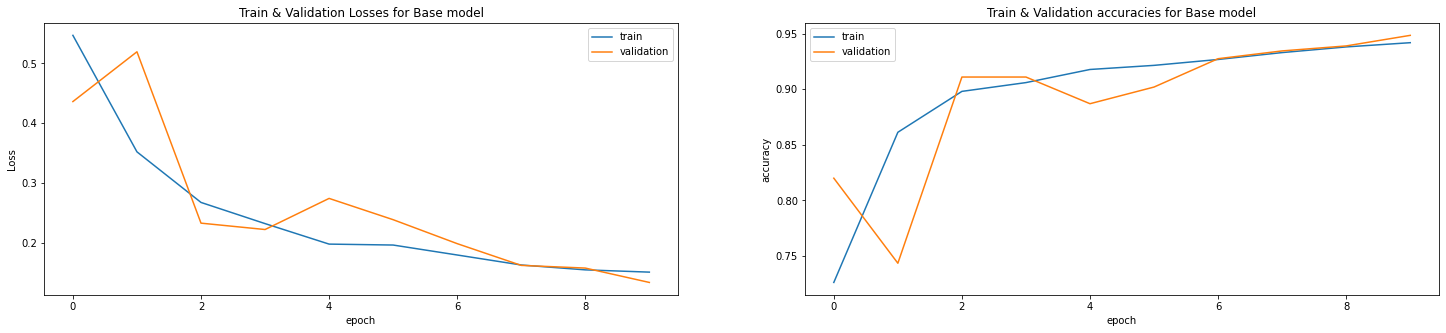

In [80]:
#plot of train loss & validation loss for the base model

fig, ax = plt.subplots(1,2,figsize = (25,5))
ax[0].plot(history_1.history['loss'])
ax[0].plot(history_1.history['val_loss'])
ax[0].legend(['train', 'validation'])
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train & Validation Losses for Base model')

#plot of train accuracy & validation accuracy for the base model

ax[1].plot(history_1.history['accuracy'])
ax[1].plot(history_1.history['val_accuracy'])
ax[1].legend(['train', 'validation'])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_title('Train & Validation accuracies for Base model')

plt.show()

In [81]:
#computing test accuracy for Unbalanced Test Dataset
test_unbalanced_acc_1 = model.evaluate(unbalanced_data,verbose=0)
print('Test Accuracy of Specified Base Model on Unbalanced Test Dataset : {}'.format(np.round(test_unbalanced_acc_1[1],3)))

#computing test accuracy for balanced Test Dataset
test_balanced_acc_1= model.evaluate(balanced_data,verbose =0)
print('Test Accuracy of Specified Base Model on Balanced Test Dataset : {}'.format(np.round(test_balanced_acc_1[1],3)))

Test Accuracy of Specified Base Model on Unbalanced Test Dataset : 0.967
Test Accuracy of Specified Base Model on Balanced Test Dataset : 0.936


# Data visualization for base model

**Description:**

In [105]:
#Opening images for visualization
test_img1 = Image.open('/kaggle/input/posthurricane/test/damage/-93.560128_30.894917.jpeg')
train_img1 = Image.open('/kaggle/input/posthurricane/train_another/damage/-93.573763_30.693981.jpeg')
test_img2 = Image.open('/kaggle/input/posthurricane/test/no_damage/-95.061936_29.828088.jpeg')
train_img2 = Image.open('/kaggle/input/posthurricane/train_another/no_damage/-95.061412_29.826522999999998.jpeg')
img_labels = [labels_test[1],labels_test[1001],labels_train[1],labels_train[5001]]
imgs = [test_img1,test_img2,train_img1,train_img2]

In [83]:
img_labels

['damage', 'no_damage', 'damage', 'no_damage']

In [106]:
#Preprocessing the images
img_data = []
for img in imgs:
    data = np.array(img)
    data = data/255.0
    data = np.expand_dims(data,axis=0)
    #print(data.shape)
    img_data.append(data)

#### Activation map for features extracted from first layer

**Description:** Activation maps give us a visual representation of how the image pixels are activated by every filter in a paricular layer. Here, we see how an image is activated after passing through the first convolution layer. 

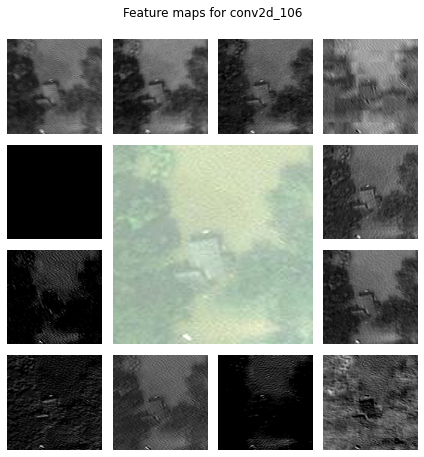

In [117]:
#Helper function used to plot the activation maps
def plot_featuremaps(img,activations,layer_names):
    fig, axs = plt.subplots(ncols=4, nrows=4,figsize = (6,6))
    gs = axs[1, 2].get_gridspec()
    # remove the underlying axes
    for ax in axs[1:-1, 1:-1]:
        ax[0].remove()
        ax[1].remove()
    axbig = fig.add_subplot(gs[1:-1, 1:-1])

    axbig.imshow(img.squeeze()+0.5)
    axbig.axis('off')

    for i, axis in enumerate(axs.ravel()):
        axis.imshow(activations.squeeze()[:,:,i], cmap='gray')
        axis.axis('off')

    fig.tight_layout()
    fig.suptitle(f'Feature maps for {layer_names[0]}',y=1.05);

#Taking the output from first convolution layer
first_conv_layer_output = model.layers[0].output

#Initializing the activation model
activation_model = Model(inputs=model.input,outputs=first_conv_layer_output)
activations = activation_model.predict(img_data[0])

#Plotting feature maps using the helper function
plot_featuremaps(img_data[0],activations,[model.layers[0].name])

**Interpretation:** This model has 32 filters in the first convolution layer. Afterimage data 1 passes through this layer, we have visualized 12 filters out of those 32 filters here. The darker shade shows the less activated parts of the image.

#### Saliency maps

**Description:** Saliency maps are a great tool to visualize which parts of the image that a model is learning to make predictions.
Here, we make use of vanilla saliency maps and GradCAM heatmaps to visualize the same.

In [86]:
#Defining score function for saliency maps and GradCAM heatmap
def score_function(index):
    if (index==0 or index==1):
        score = BinaryScore(0.0)
    else:
        score = BinaryScore(1.0)
    return score

#Creating a dictionary for labels
label_dict = {1: 'no_damage', 0: 'damage'}

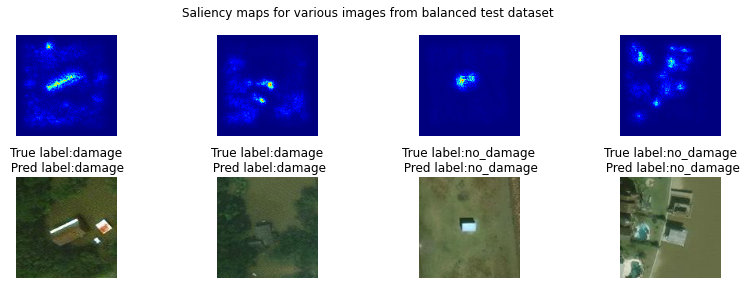

In [87]:
#Creating subplots for the saliency maps
fig,ax = plt.subplots(2,4,figsize=(12, 4))

#Initializing a saliency model
saliency_model = Saliency(model,model_modifier=ReplaceToLinear(),clone=True)
for i in range(4):
    saliency_map = saliency_model(score_function(i),test_img_data[i])
    
    ax[1,i].imshow(imgs[i])
    img_pred = np.round(model.predict(img_data[i]).flatten()[0])
    ax[1,i].set_title(f'True label:{img_labels[i]}\n Pred label:{label_dict[img_pred]}')
    ax[1,i].axis('off')

    ax[0,i].imshow(saliency_map[0], cmap='jet')
    #ax[1,i].set_title(f'True label:{test_img_labels[i]}')
    ax[0,i].axis('off')

fig.suptitle('Saliency maps for various images from balanced test dataset')
plt.tight_layout()
plt.show()

**Interpretation:** The part of the image highlighted in white shows where the model is looking at while training. In these images, we can see that the model learns well.

#### Grad-CAM heatmaps

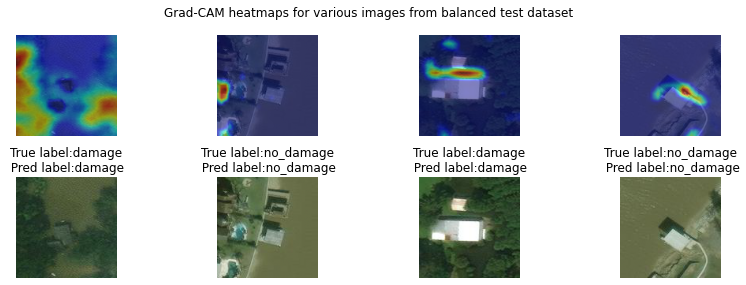

In [90]:
#Creating subplots for the GradCAM heatmaps
fig,ax = plt.subplots(2,4,figsize=(12, 4))

#Initializing a heatmap function
gradcam = Gradcam(model,model_modifier=ReplaceToLinear(),clone=True)
for i in range(4):
    cam = gradcam(score_function(i),img_data[i])

    heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
    
    ax[1,i].imshow(img_data[i][0])
    img_pred = np.round(model.predict(img_data[i]).flatten()[0])
    ax[1,i].set_title(f'True label:{img_labels[i]}\n Pred label:{label_dict[img_pred]}')
    ax[1,i].axis('off')

    ax[0,i].imshow(img_data[i][0])
    ax[0,i].imshow(heatmap[0], cmap='jet', alpha=0.5) # overlay
    #ax[0,1].set_title(f'Label:{val_img_labels[i]}')
    ax[0,i].axis('off')

fig.suptitle('Grad-CAM heatmaps for various images from balanced test dataset')
plt.tight_layout()
plt.show()

**Interpretation:** GradCAM shows the part of the image used for learning and prediction in red and the rest of the parts in blue. In most of the images, we can clearly see that it is learning an incorrect part, though it provides a correct prediction.

# Image Occlusion

**Description:** Image occlusion is also a visulization technique.It is used to represent how much each pixel is activated by the model while learning the image.

In [91]:
#Helper function to create patched images
def apply_grey_patch(image, top_left_x, top_left_y, patch_size):
    patched_image = np.array(image, copy=True)
    patched_image[:,top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] = 127.5
    return patched_image

In [92]:
#Function to perform image occlusion
def occlusion(model,img,img_label,patch_size=5):
    
    label_dict = {1: 'no_damage', 0: 'damage'}
    
    patch_size = patch_size
    
    #Calculating the loss of the image
    loss = model.evaluate(img,np.array(img_label).reshape(1,1), verbose=0)
    
    #Creating a loss map array
    loss_map = np.zeros((img.shape[1], img.shape[2]))

    # Iterate the patch over the entire image
    for top_left_x in range(0, img.shape[1], patch_size):

        for top_left_y in range(0, img.shape[2], patch_size):
  
            # Initialise a new patched image
            patched_image = apply_grey_patch(img, top_left_x, top_left_y, patch_size)

            # Get the loss of the model for each patched version
            result = model.evaluate(patched_image, np.array(img_label).reshape(1,1), verbose=0)

            # Get the loss_map of the plot by computing the difference in loss from the original version to the patched value
            loss_map[top_left_y:top_left_y + patch_size, top_left_x:top_left_x + patch_size] = loss[0] - result[0]

    #Predicting on the image
    y_prob = np.round(model.predict(img).flatten()[0])
    y_pred = label_dict[y_prob]

    y_true = label_dict[img_label]


    # Plot the original image along with the difference in loss as a heatmap
    fig, ax = plt.subplots(1,2, figsize=(15,15))

    plt.figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')
    ax[0].imshow(img.reshape(128,128,3))
    ax[1].imshow(img.reshape(128,128,3), cmap='gray')
    im = ax[1].imshow(loss_map, cmap='Reds', alpha=0.4)
    fig.colorbar(im,fraction=0.05)
    ax[0].set_title("True Label: "+str(y_true), fontsize=15)
    ax[1].set_title("Predicted label with patch size "+str(patch_size)+": "+str(y_pred), fontsize=15)

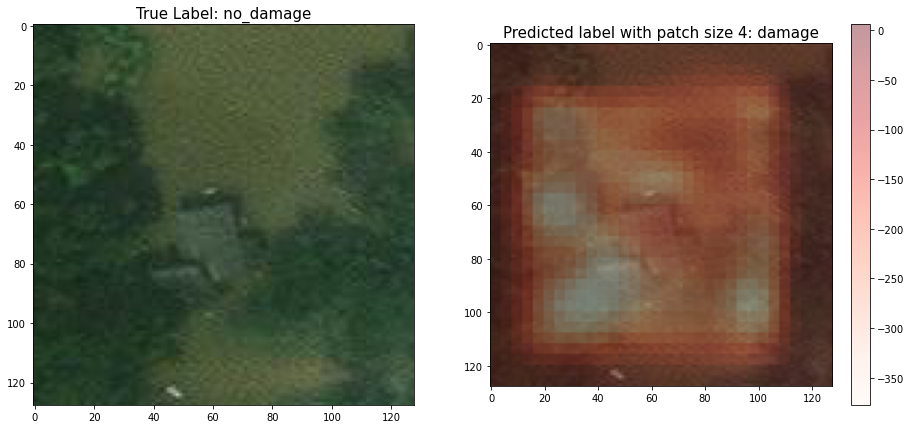

<Figure size 800x600 with 0 Axes>

In [93]:
#Calling the occlusion function
#img_label = test_img_labels[0]
occ = occlusion(model,img_data[0],img_label=1, patch_size=4)

**Interpretation:** In this image,the pixels highlighted in white show where the model is focusing the most. It is appropriately learning this image.

# **Regularised Model**

Now after building the base model to further improve the test accuracy we are going to build a regularized model.

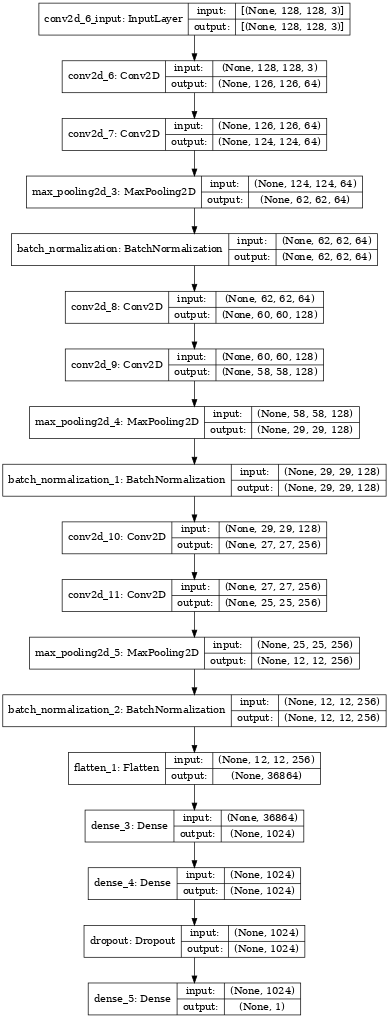

In [27]:
from tensorflow.keras.layers import Conv2D,MaxPool2D,Dense,Flatten
from tensorflow.keras import regularizers
# Initialize a sequential model
model_reg = Sequential(name="Regularized_Model")

#Convolutional layers with 64 filters with relu activation and kernel size as 3
model_reg.add(Conv2D(64,kernel_size =(3, 3), activation='relu',input_shape=(128,128,3)))
model_reg.add(Conv2D(64,kernel_size =(3,3), activation='relu'))

#MaxPooling layer with pool size 2
model_reg.add(MaxPool2D(pool_size=(2, 2)))

#Regulating by batchnormalization
model_reg.add(BatchNormalization())

#Convolutional layers with 128 filters with relu activation and kernel size as 3
model_reg.add(Conv2D(128,kernel_size =(3,3), activation='relu'))
model_reg.add(Conv2D(128,kernel_size =(3,3), activation='relu'))

#MaxPooling layer with pool size 2
model_reg.add(MaxPool2D(pool_size=(2, 2)))

#Regulating by batchnormalization
model_reg.add(BatchNormalization())

#Convolutional layers with 256 filters with relu activation and kernel size as 3
model_reg.add(Conv2D(256,kernel_size =(3,3), activation='relu'))
model_reg.add(Conv2D(256,kernel_size =(3,3), activation='relu'))

#MaxPooling layer with pool size 2
model_reg.add(MaxPool2D(pool_size=(2, 2)))

#Regulating by batchnormalization
model_reg.add(BatchNormalization())

#Flatten Layer
model_reg.add(Flatten())

#Two Dense layers with 1024 neurons each with relu activation
model_reg.add(Dense(1024,activation='relu'))
model_reg.add(Dense(1024,activation='relu'))
 
#Dropout Layer wiith value 0.1
model_reg.add(Dropout(0.1))

#Output layer with 1 neuron and with sigmoid activation as it's a binary classification problem
model_reg.add(Dense(1,activation = 'sigmoid'))

#plot_model
tensorflow.keras.utils.plot_model(model_reg, "reg_model.png", show_shapes=True,dpi =50)

In [28]:
# Compiling the model
model_reg.compile(optimizer=tensorflow.keras.optimizers.Adam(learning_rate = 1e-4), loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
history_2 = model.fit(train_data,validation_data=val_data,epochs=10)

Epoch 1/10
157/157 [==============================] - 70s 448ms/step - loss: 0.1457 - accuracy: 0.9420 - val_loss: 0.1631 - val_accuracy: 0.9400
Epoch 2/10
157/157 [==============================] - 76s 482ms/step - loss: 0.1441 - accuracy: 0.9425 - val_loss: 0.1133 - val_accuracy: 0.9550
Epoch 3/10
157/157 [==============================] - 73s 462ms/step - loss: 0.1444 - accuracy: 0.9415 - val_loss: 0.1533 - val_accuracy: 0.9420
Epoch 4/10
157/157 [==============================] - 65s 411ms/step - loss: 0.1287 - accuracy: 0.9496 - val_loss: 0.1170 - val_accuracy: 0.9520
Epoch 5/10
157/157 [==============================] - 63s 404ms/step - loss: 0.1188 - accuracy: 0.9547 - val_loss: 0.1720 - val_accuracy: 0.9360
Epoch 6/10
157/157 [==============================] - 57s 365ms/step - loss: 0.1316 - accuracy: 0.9464 - val_loss: 0.1254 - val_accuracy: 0.9565
Epoch 7/10
157/157 [==============================] - 60s 382ms/step - loss: 0.1073 - accuracy: 0.9580 - val_loss: 0.1009 - val_ac

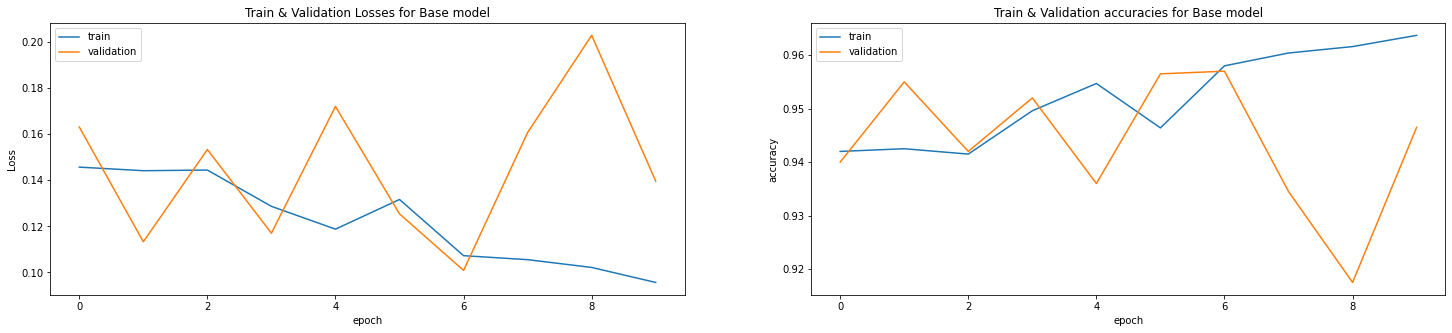

In [30]:
#plot of train loss & validation loss for the regularized model

fig, ax = plt.subplots(1,2,figsize = (25,5))
ax[0].plot(history_2.history['loss'])
ax[0].plot(history_2.history['val_loss'])
ax[0].legend(['train', 'validation'])
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('Loss')
ax[0].set_title('Train & Validation Losses for Base model')

#plot of train accuracy & validation accuracy for the base model

ax[1].plot(history_2.history['accuracy'])
ax[1].plot(history_2.history['val_accuracy'])
ax[1].legend(['train', 'validation'])
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].set_title('Train & Validation accuracies for Base model')

plt.show()

In [31]:
#computing test accuracy for Unbalanced Test Dataset
test_unbalanced_acc_2 = model_reg.evaluate(unbalanced_data,verbose=0)
print('Test Accuracy of Regularised Model on Unbalanced Test Dataset : {}'.format(np.round(test_unbalanced_acc_2[1],3)))

#computing test accuracy for Balanced Test Dataset
test_balanced_acc_2= model_reg.evaluate(balanced_data,verbose =0)
print('Test Accuracy of Regularised Model on Balanced Test Dataset : {}'.format(np.round(test_balanced_acc_2[1],3)))

Test Accuracy of Regularised Model on Unbalanced Test Dataset : 0.889
Test Accuracy of Regularised Model on Balanced Test Dataset : 0.5


### Grad CAM heatmap for regularized model

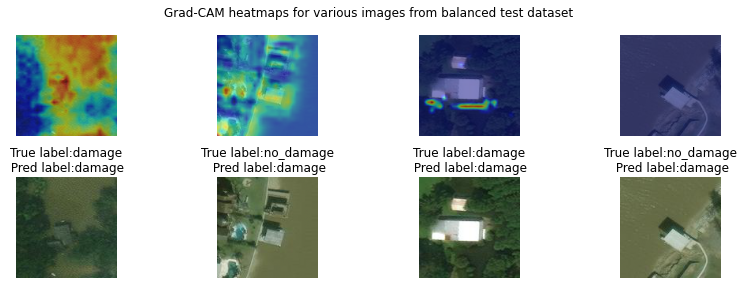

In [94]:
#Creating subplots for the GradCAM heatmaps
fig,ax = plt.subplots(2,4,figsize=(12, 4))

#Initializing a heatmap function
gradcam = Gradcam(model_reg,model_modifier=ReplaceToLinear(),clone=True)
for i in range(4):
    cam = gradcam(score_function(i),img_data[i])

    heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
    
    ax[1,i].imshow(img_data[i][0])
    img_pred = np.round(model_reg.predict(img_data[i]).flatten()[0])
    ax[1,i].set_title(f'True label:{img_labels[i]}\n Pred label:{label_dict[img_pred]}')
    ax[1,i].axis('off')

    ax[0,i].imshow(img_data[i][0])
    ax[0,i].imshow(heatmap[0], cmap='jet', alpha=0.5) # overlay
    #ax[0,1].set_title(f'Label:{val_img_labels[i]}')
    ax[0,i].axis('off')

fig.suptitle('Grad-CAM heatmaps for various images from balanced test dataset')
plt.tight_layout()
plt.show()

# **SOTA Models**

 ***Now , we will be using the transfer learning approach to create different models using***
 ***various SOTA models - ResNet-50, VGGNet (VGG19) , Inception-V3 and MobileNet***

We will be using pretrained weights from the ImageNet dataset. Although the ImageNet 
dataset do not satellite images , CNNs pre-trained on ImageNet have shown the ability to accurately predict even this category of classification

# ResNet-50

ResNet-50 is a 50 layer deep Neural Network architecture used for image classification and object detection

![](https://miro.medium.com/max/1100/0*9LqUp7XyEx1QNc6A.webp)

In [34]:
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input as prep_res
# Using the resnet architecture
ResNmodel = ResNet50(input_shape=(128,128,3),weights='imagenet',include_top = False)
# Importing the mobilenet model with pre-trained imagenet weights

ResNmodel = Model(inputs=ResNmodel.input, outputs=ResNmodel.layers[-1].output)

ResNmodel.layers[-1].output

94781440/94765736 [==============================] - 1s 0us/step


<KerasTensor: shape=(None, 4, 4, 2048) dtype=float32 (created by layer 'conv5_block3_out')>

In [35]:
x=ResNmodel.output
x=Flatten()(x)
# On top of mobile net, add a few dense layers with 'relu' activation
# Using functional API, add a dense layer with 1024 neurons
x = Dropout(rate = 0.5)(x)
x=Dense(2048,activation= 'relu')(x)
x = Dropout(rate = 0.5)(x)
# Adding a dense layer with 512 neurons
x=Dense(1024,activation = 'relu')(x)
x = Dropout(rate = 0.5)(x)
x=Dense(512,activation = 'relu')(x)
x = Dropout(rate = 0.5)(x)
x= Dense(128,activation = 'relu')(x)
# Addinh a final layer with 1 neuron and sigmoid activation 
preds=Dense(1,activation = 'sigmoid')(x) 

In [36]:
model_resn=Model(ResNmodel.input,preds)

As the Resnet-50 accept the images of input shape (224,224,3), we are setting the target size of the images in flow_from_directory to be (224,224) and color_mode to be rgb

Creating a function that accepts the preprocessing_function and target size as parameters and returns the *train_data*, *validation_data*, *unbalanced_test_data* and *balanced_test_data* and they will be used for all the SOTA models

In [37]:
# Using the `ImageDataGenerator` function from keras to generate new images based on our existing ones
# Mentioning the preprocessing function as ResNet's preprocess_input and specify a9 validation split of 20%
def data_generator(preprocess_input,target_size):
        datagen=ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=10, # rotation
                                   width_shift_range=0.2, # horizontal shift
                                   height_shift_range=0.3, # vertical shift
                                   zoom_range=0.4, # zoom
                                   horizontal_flip=True,# horizontal flip
                                    #re-scaling
                                   brightness_range=[0.3,1.1]) # brightness)

        datagen_2=ImageDataGenerator(preprocessing_function=preprocess_input,rotation_range=10, # rotation
                                   width_shift_range=0.2, # horizontal shift
                                   height_shift_range=0.3, # vertical shift
                                   zoom_range=0.4, # zoom
                                   horizontal_flip=True,# horizontal flip
                                    #re-scaling
                                   brightness_range=[0.3,1.1])
        test_unbalanced_gen_2 =  ImageDataGenerator(preprocessing_function=preprocess_input)
        test_balanced_gen_2 =  ImageDataGenerator(preprocessing_function=preprocess_input)

        train_data=datagen.flow_from_directory(  directory = train_directory,
                                       target_size = target_size,
                                           class_mode = 'binary',
                                                                            
                                           batch_size=16)


        validation_data=datagen_2.flow_from_directory( directory = validation_directory,
                                              target_size = target_size,
                                                  class_mode = 'binary',
                                                  
                                                  batch_size=16)

        unbalanced_data = test_unbalanced_gen_2.flow_from_directory(directory =unbalanced_test_directory,
                                                          target_size = target_size,
                                                          class_mode = 'binary',
                                                          
                                                          batch_size=16)

        balanced_data = test_balanced_gen_2.flow_from_directory(directory =balanced_test_directory,
                                                          target_size = target_size,
                                                          class_mode = 'binary',
                                                          
                                                          batch_size=16)
        return train_data,validation_data,unbalanced_data,balanced_data


In [38]:
model_resn.compile(optimizer = tensorflow.keras.optimizers.Adam(2e-4),loss = tensorflow.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])

In [39]:
print(data_generator(prep_res,(128,128)))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
(<keras.preprocessing.image.DirectoryIterator object at 0x7f4e4a0e9d90>, <keras.preprocessing.image.DirectoryIterator object at 0x7f4ec96047d0>, <keras.preprocessing.image.DirectoryIterator object at 0x7f4ec9604950>, <keras.preprocessing.image.DirectoryIterator object at 0x7f4ec9604e50>)


***Preprocess_input* for ResNet50 does the following preprocessing steps on the images**:

1. Scaling the image values by the standard deviation of the ImageNet dataset

2. The ResNet50 model was trained on the ImageNet dataset, which has a specific mean RGB value. This function subtracts these mean RGB values from the input image to ensure that the image has zero mean.

3. The ResNet50 model was trained on images in the BGR color space, so this function converts the input image to the BGR color space.

In [40]:
train_data_1,validation_data_1,unbalanced_data_1,balanced_data_1 = data_generator(prep_res,(128,128))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [41]:
step_size_train=train_data_1.n//train_data_1.batch_size
step_size_validation=validation_data_1.n//validation_data_1.batch_size

model_resn.fit(train_data_1,validation_data=validation_data_1,epochs =10,batch_size = 64)

Epoch 1/10
625/625 [==============================] - 95s 143ms/step - loss: 0.5222 - accuracy: 0.8226 - val_loss: 0.4700 - val_accuracy: 0.7905
Epoch 2/10
625/625 [==============================] - 86s 137ms/step - loss: 0.3227 - accuracy: 0.9003 - val_loss: 0.3328 - val_accuracy: 0.8795
Epoch 3/10
625/625 [==============================] - 82s 131ms/step - loss: 0.1927 - accuracy: 0.9311 - val_loss: 0.1683 - val_accuracy: 0.9380
Epoch 4/10
625/625 [==============================] - 81s 129ms/step - loss: 0.1931 - accuracy: 0.9375 - val_loss: 0.1046 - val_accuracy: 0.9650
Epoch 5/10
625/625 [==============================] - 82s 132ms/step - loss: 0.1711 - accuracy: 0.9407 - val_loss: 0.1105 - val_accuracy: 0.9630
Epoch 6/10
625/625 [==============================] - 83s 132ms/step - loss: 0.1513 - accuracy: 0.9489 - val_loss: 0.0747 - val_accuracy: 0.9705
Epoch 7/10
625/625 [==============================] - 120s 192ms/step - loss: 0.1883 - accuracy: 0.9413 - val_loss: 1.7978 - val_a

In [42]:
test_unbalanced_acc_3 = model_resn.evaluate(unbalanced_data_1,verbose=0)
print('Test Accuracy of model_resn on Unbalanced Test Dataset : {}'.format(np.round(test_unbalanced_acc_3[1],3)))
test_balanced_acc_3= model_resn.evaluate(balanced_data_1,verbose =0)
print('Test Accuracy of model_resn on Balanced Test Dataset : {}'.format(np.round(test_balanced_acc_3[1],3)))


Test Accuracy of model_resn on Unbalanced Test Dataset : 0.844
Test Accuracy of model_resn on Balanced Test Dataset : 0.919


### Grad-CAM heatmap

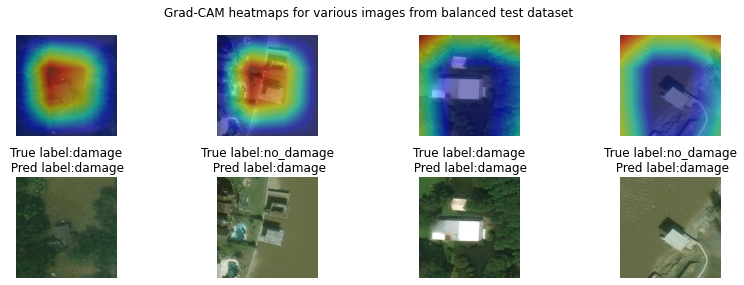

In [95]:
#Creating subplots for the GradCAM heatmaps
fig,ax = plt.subplots(2,4,figsize=(12, 4))

#Initializing a heatmap function
gradcam = Gradcam(model_resn,model_modifier=ReplaceToLinear(),clone=True)
for i in range(4):
    cam = gradcam(score_function(i),img_data[i])

    heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
    
    ax[1,i].imshow(img_data[i][0])
    img_pred = np.round(model_resn.predict(img_data[i]).flatten()[0])
    ax[1,i].set_title(f'True label:{img_labels[i]}\n Pred label:{label_dict[img_pred]}')
    ax[1,i].axis('off')

    ax[0,i].imshow(img_data[i][0])
    ax[0,i].imshow(heatmap[0], cmap='jet', alpha=0.5) # overlay
    #ax[0,1].set_title(f'Label:{val_img_labels[i]}')
    ax[0,i].axis('off')

fig.suptitle('Grad-CAM heatmaps for various images from balanced test dataset')
plt.tight_layout()
plt.show()

# VGG-19


The VGG-19 model consists of 19 layers, including 16 convolutional layers, 3 fully-connected (FC) layers, and a final classification layer. It is a variant of the VGG-16 model, which was developed by the ***Visual Geometry Group*** group in the same year. Both models architecture are very simple yet effective

![](https://blog.techcraft.org/wp-content/uploads/2021/03/vgg19-architecture2.png)

In [44]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as prep_vgg
# Using the VGGnet architecture
VGGmodel = VGG19(input_shape = (128,128,3),weights='imagenet',include_top = False)
# Importing the VGGnet model with pre-trained imagenet weights
# Discarding the last 1000 neuron layer ie. the final fully connected layer
VGGmodel = Model(inputs=VGGmodel.input, outputs=VGGmodel.layers[-3].output)
VGGmodel.layers[-3].output

80150528/80134624 [==============================] - 0s 0us/step


<KerasTensor: shape=(None, 8, 8, 512) dtype=float32 (created by layer 'block5_conv1')>

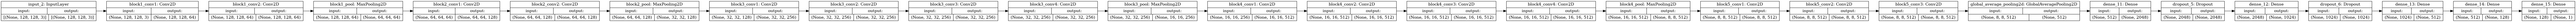

In [45]:
from keras.utils.vis_utils import plot_model
x=VGGmodel.output

x=GlobalAveragePooling2D()(x)
# On top of mobile net, add a few dense layers with 'relu' activation
# Using functional API, add a dense layer with 2048 neurons 
x=Dense(2048)(x)
x = Dropout(rate = 0.4)(x)
x=Dense(1024)(x)
x= Dropout(rate = 0.2)(x)
x=Dense(512)(x)
# Adding a dense layer with 512 neurons
x=Dense(128)(x)
# Addinh a final layer with 1 neuron and sigmoid activation 
preds=Dense(1,activation = 'sigmoid')(x) 

model_VGG=Model(VGGmodel.input,preds)

plot_model(model_VGG, to_file='model.png', show_shapes=True, rankdir='LR')

In [46]:
model_VGG.compile(optimizer = tensorflow.keras.optimizers.Adam(1e-4),loss = tensorflow.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])

***Preprocess_input* for VGG19 does the following preprocessing steps on the images**:

1. Resizing the input image to have the same size as the images used for training the VGG-19 model, but we overrode this using the target_size in flow_from_directory 

2. The VGG-19 model was trained on images in the BGR color space, so the input images are converted to this color space before being fed into the model.

3. Normalizing the pixel values of the input image. .

In [47]:
train_data_2,validation_data_2,unbalanced_data_2,balanced_data_2 = data_generator(prep_vgg,(128,128))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [48]:
step_size_train=train_data_2.n//train_data_2.batch_size
step_size_validation=validation_data_2.n//validation_data_2.batch_size

model_VGG.fit(train_data_2, steps_per_epoch=step_size_train,validation_data=validation_data_2,epochs =10, validation_steps=step_size_validation)

Epoch 1/10
625/625 [==============================] - 82s 128ms/step - loss: 0.4882 - accuracy: 0.7937 - val_loss: 0.1816 - val_accuracy: 0.9335
Epoch 2/10
625/625 [==============================] - 78s 125ms/step - loss: 0.1950 - accuracy: 0.9205 - val_loss: 0.2740 - val_accuracy: 0.8875
Epoch 3/10
625/625 [==============================] - 78s 124ms/step - loss: 0.1695 - accuracy: 0.9315 - val_loss: 0.1073 - val_accuracy: 0.9530
Epoch 4/10
625/625 [==============================] - 78s 125ms/step - loss: 0.1319 - accuracy: 0.9500 - val_loss: 0.1166 - val_accuracy: 0.9560
Epoch 5/10
625/625 [==============================] - 79s 126ms/step - loss: 0.1195 - accuracy: 0.9551 - val_loss: 0.1588 - val_accuracy: 0.9395
Epoch 6/10
625/625 [==============================] - 83s 132ms/step - loss: 0.1037 - accuracy: 0.9613 - val_loss: 0.1295 - val_accuracy: 0.9550
Epoch 7/10
625/625 [==============================] - 80s 127ms/step - loss: 0.1033 - accuracy: 0.9621 - val_loss: 0.1140 - val_ac

In [49]:
test_unbalanced_acc_4 = model_VGG.evaluate(unbalanced_data_2,verbose=0)
test_balanced_acc_4= model_VGG.evaluate(balanced_data_2,verbose =0)

In [50]:
print('Test Accuracy of model_VGG on Unbalanced Test Dataset : {:.3f}'.format(np.round(test_unbalanced_acc_4[1],3)))
print('Test Accuracy of model_VGG on Balanced Test Dataset : {:.3f}'.format(np.round(test_balanced_acc_4[1],3)))

Test Accuracy of model_VGG on Unbalanced Test Dataset : 0.987
Test Accuracy of model_VGG on Balanced Test Dataset : 0.988


**GradCAM heatmap**

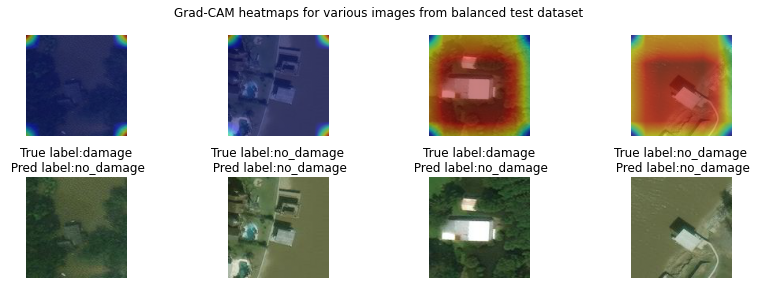

In [96]:
#Creating subplots for the GradCAM heatmaps
fig,ax = plt.subplots(2,4,figsize=(12, 4))

#Initializing a heatmap function
gradcam = Gradcam(model_VGG,model_modifier=ReplaceToLinear(),clone=True)
for i in range(4):
    cam = gradcam(score_function(i),img_data[i])

    heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
    
    ax[1,i].imshow(img_data[i][0])
    img_pred = np.round(model_VGG.predict(img_data[i]).flatten()[0])
    ax[1,i].set_title(f'True label:{img_labels[i]}\n Pred label:{label_dict[img_pred]}')
    ax[1,i].axis('off')

    ax[0,i].imshow(img_data[i][0])
    ax[0,i].imshow(heatmap[0], cmap='jet', alpha=0.5) # overlay
    #ax[0,1].set_title(f'Label:{val_img_labels[i]}')
    ax[0,i].axis('off')

fig.suptitle('Grad-CAM heatmaps for various images from balanced test dataset')
plt.tight_layout()
plt.show()

# Inception V-3

Inception v3 is a convolutional neural network (CNN) trained to classify images into a set of predefined classes. It was developed by Google researchers and was published in 2015 as part of the ILSVRC (ImageNet Large Scale Visual Recognition Challenge).It has also been used in a variety of research projects, including those focused on image recognition, object detection, and image generation.
Here, we would be using this architecture with pretrained(imagenet) weights for classification

![](https://media.geeksforgeeks.org/wp-content/uploads/20200502220903/Inception-V4.PNG)

In [52]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as prep_inc
INCmodel = InceptionV3(input_shape = (150,150,3),weights='imagenet',include_top = False)
# Importing the Inception V3 model with pre-trained imagenet weights
# Discarding the last 1000 neuron layer ie. the final fully connected layer
INCmodel = Model(inputs=INCmodel.input, outputs=INCmodel.layers[-3].output)

INCmodel.layers[-3].output

87924736/87910968 [==============================] - 0s 0us/step


<KerasTensor: shape=(None, 3, 3, 384) dtype=float32 (created by layer 'activation_91')>

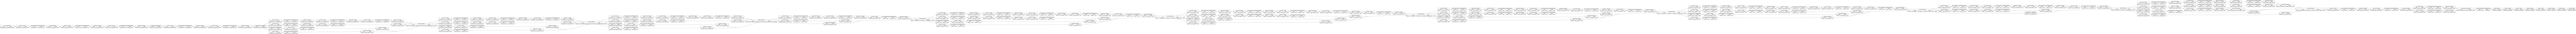

In [53]:
x=INCmodel.output
x=tensorflow.keras.layers.GlobalMaxPooling2D()(x)
# Using functional API, add a dense layer with 2048 neurons 
x=Dense(2048)(x)
x = Dropout(rate =0.5)(x)
# Adding a dense layer with 1024 neurons
x=Dense(1024)(x)
x = Dropout(rate =0.3)(x)
x=Dense(512)(x)
x = Dropout(rate =0.1)(x)
x=Dense(128)(x)
# Adding a final layer with 1 neuron and sigmoid activation 
preds=Dense(1,activation = 'sigmoid')(x) 

model_INC=Model(INCmodel.input,preds)
plot_model(model_INC, to_file='model.png', show_shapes=True, rankdir='LR')

***Preprocess_input* for Inception- V3 does the following preprocessing steps on the images**:

1. Resizing the input image to have the same size as the images used for training the Inception-v3 model, but we overrode this using the target_size in flow_from_directory 

2. The Inception-V3 model was trained on images in the BGR color space, so the input images are converted to this color space before being fed into the model.

3. Normalizing the pixel values of the input image.


In [54]:
train_data_3,validation_data_3,unbalanced_data_3,balanced_data_3 = data_generator(prep_inc,(150,150))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [55]:
model_INC.compile(optimizer = tensorflow.keras.optimizers.Adam(2e-4),loss = tensorflow.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])

In [56]:
step_size_train=train_data_3.n//train_data_3.batch_size
step_size_validation=validation_data_3.n//validation_data_3.batch_size

model_INC.fit(train_data_3, steps_per_epoch=step_size_train,validation_data=validation_data_3,epochs =5, validation_steps=step_size_validation)

Epoch 1/5
625/625 [==============================] - 107s 161ms/step - loss: 0.3840 - accuracy: 0.8653 - val_loss: 0.1587 - val_accuracy: 0.9455
Epoch 2/5
625/625 [==============================] - 100s 160ms/step - loss: 0.1761 - accuracy: 0.9339 - val_loss: 0.1891 - val_accuracy: 0.9225
Epoch 3/5
625/625 [==============================] - 97s 156ms/step - loss: 0.1279 - accuracy: 0.9513 - val_loss: 0.1672 - val_accuracy: 0.9310
Epoch 4/5
625/625 [==============================] - 98s 156ms/step - loss: 0.1121 - accuracy: 0.9576 - val_loss: 0.1629 - val_accuracy: 0.9400
Epoch 5/5
625/625 [==============================] - 103s 164ms/step - loss: 0.1226 - accuracy: 0.9551 - val_loss: 0.1304 - val_accuracy: 0.9620


In [57]:
test_unbalanced_acc_5 = model_INC.evaluate(unbalanced_data_3,verbose=0)
test_balanced_acc_5= model_INC.evaluate(balanced_data_3,verbose =0)

In [58]:
print('Test Accuracy of model_INC on Unbalanced Test Dataset : {:.3f}'.format(np.round(test_unbalanced_acc_5[1],3)))
print('Test Accuracy of model_INC on Balanced Test Dataset : {:.3f}'.format(np.round(test_balanced_acc_5[1],3)))

Test Accuracy of model_INC on Unbalanced Test Dataset : 0.992
Test Accuracy of model_INC on Balanced Test Dataset : 0.972


Grad-CAM heatmap

In [101]:
#Preprocessing the images
img_data = []
for img in imgs:
    data = np.array(img)
    data = np.resize(data,(150,150,3))
    data = data/255.0
    data = np.expand_dims(data,axis=0)
    #print(data.shape)
    img_data.append(data)

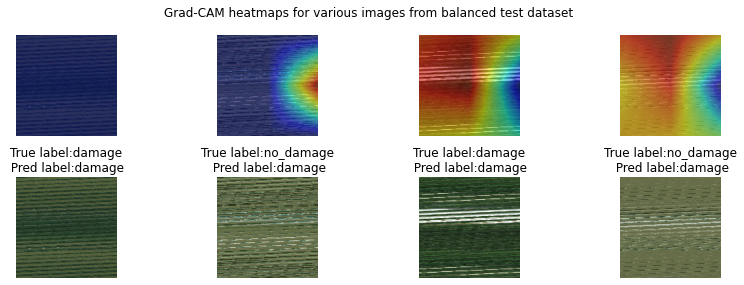

In [102]:
#Creating subplots for the GradCAM heatmaps
fig,ax = plt.subplots(2,4,figsize=(12, 4))

#Initializing a heatmap function
gradcam = Gradcam(model_INC,model_modifier=ReplaceToLinear(),clone=True)
for i in range(4):
    cam = gradcam(score_function(i),img_data[i])

    heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
    
    ax[1,i].imshow(img_data[i][0])
    img_pred = np.round(model_INC.predict(img_data[i]).flatten()[0])
    ax[1,i].set_title(f'True label:{img_labels[i]}\n Pred label:{label_dict[img_pred]}')
    ax[1,i].axis('off')

    ax[0,i].imshow(img_data[i][0])
    ax[0,i].imshow(heatmap[0], cmap='jet', alpha=0.5) # overlay
    #ax[0,1].set_title(f'Label:{val_img_labels[i]}')
    ax[0,i].axis('off')

fig.suptitle('Grad-CAM heatmaps for various images from balanced test dataset')
plt.tight_layout()
plt.show()

# MobileNet

MobileNet is a 53-layer deep Neural Network architecture designed for image classification and object detection tasks. Since it is fast and efficient, it works pretty well on resource-constraint systems and mobile devices. For this model as well, we will be using pre-trained imagenet weights as starting point of training

![](https://miro.medium.com/max/1100/1*7R068tzqqK-1edu4hbAVZQ.webp)

In [60]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input as prep_mob
MobNmodel = MobileNet(input_shape=(128,128,3),
    include_top=False,
    weights='imagenet')
MobNmodel = Model(inputs=MobNmodel.input, outputs=MobNmodel.layers[-1].output)

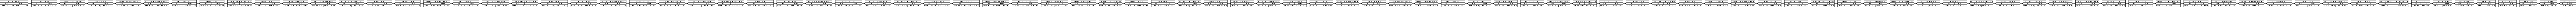

In [61]:
x=MobNmodel.output
x=tensorflow.keras.layers.GlobalMaxPooling2D()(x)
# Using functional API, add a dense layer with 2048 neurons 
x=Dense(2048)(x)
x = Dropout(rate =0.5)(x)
# Adding a dense layer with 1024 neurons
x=Dense(1024)(x)
x = Dropout(rate =0.3)(x)
x=Dense(512)(x)
x = Dropout(rate =0.1)(x)
x=Dense(128)(x)
# Adding a final layer with 1 neuron and sigmoid activation 
preds=Dense(1,activation = 'sigmoid')(x) 

model_MobN=Model(MobNmodel.input,preds)
plot_model(model_MobN, to_file='model2.png', show_shapes=True, rankdir='LR')

***Preprocess_input* for MobileNet does the following preprocessing steps on the images**:

1. It subtracts the mean pixel value from each of the pixels of the image to make then centered around 0

2. Rescaling the images by dividing by 255

3. Performing the channel-wise color normalization for each of the images


In [62]:
train_data_4,validation_data_4,unbalanced_data_4,balanced_data_4 = data_generator(prep_mob,(128,128))

Found 10000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.
Found 9000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


In [63]:
model_MobN.compile(optimizer = tensorflow.keras.optimizers.Adam(2e-4),loss = tensorflow.keras.losses.BinaryCrossentropy(),metrics = ['accuracy'])

In [64]:
step_size_train=train_data_4.n//train_data_4.batch_size
step_size_validation=validation_data_4.n//validation_data_4.batch_size

model_MobN.fit(train_data_4, steps_per_epoch=step_size_train,validation_data=validation_data_4,epochs =5, validation_steps=step_size_validation)

Epoch 1/5
625/625 [==============================] - 78s 119ms/step - loss: 1.3446 - accuracy: 0.8379 - val_loss: 0.2182 - val_accuracy: 0.9490
Epoch 2/5
625/625 [==============================] - 73s 117ms/step - loss: 0.2932 - accuracy: 0.9136 - val_loss: 0.1224 - val_accuracy: 0.9585
Epoch 3/5
625/625 [==============================] - 74s 119ms/step - loss: 0.2311 - accuracy: 0.9246 - val_loss: 0.0831 - val_accuracy: 0.9640
Epoch 4/5
625/625 [==============================] - 73s 117ms/step - loss: 0.1849 - accuracy: 0.9373 - val_loss: 0.0842 - val_accuracy: 0.9690
Epoch 5/5
625/625 [==============================] - 75s 119ms/step - loss: 0.1493 - accuracy: 0.9471 - val_loss: 0.1464 - val_accuracy: 0.9335


In [65]:
test_unbalanced_acc_6 = model_MobN.evaluate(unbalanced_data_4,verbose=0)
test_balanced_acc_6= model_MobN.evaluate(balanced_data_4,verbose =0)

In [66]:
print('Test Accuracy of model_MobN on Unbalanced Test Dataset : {:.3f}'.format(np.round(test_unbalanced_acc_6[1],3)))
print('Test Accuracy of model_MobN on Balanced Test Dataset : {:.3f}'.format(np.round(test_balanced_acc_6[1],3)))

Test Accuracy of model_MobN on Unbalanced Test Dataset : 0.909
Test Accuracy of model_MobN on Balanced Test Dataset : 0.945


Grad_CAM heatmap

In [99]:
#Preprocessing the images
img_data = []
for img in imgs:
    data = np.array(img)
    data = data/255.0
    data = np.expand_dims(data,axis=0)
    #print(data.shape)
    img_data.append(data)

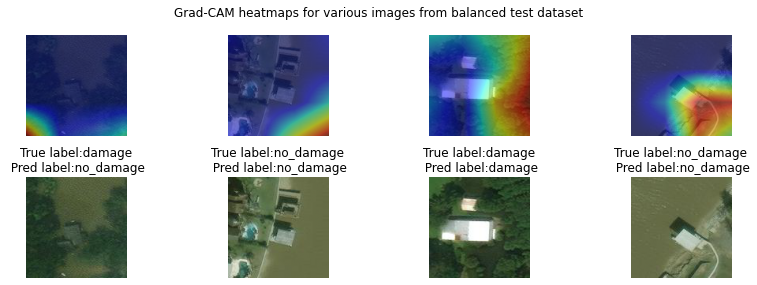

In [100]:
#Creating subplots for the GradCAM heatmaps
fig,ax = plt.subplots(2,4,figsize=(12, 4))

#Initializing a heatmap function
gradcam = Gradcam(model_MobN,model_modifier=ReplaceToLinear(),clone=True)
for i in range(4):
    cam = gradcam(score_function(i),img_data[i])

    heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
    
    ax[1,i].imshow(img_data[i][0])
    img_pred = np.round(model_MobN.predict(img_data[i]).flatten()[0])
    ax[1,i].set_title(f'True label:{img_labels[i]}\n Pred label:{label_dict[img_pred]}')
    ax[1,i].axis('off')

    ax[0,i].imshow(img_data[i][0])
    ax[0,i].imshow(heatmap[0], cmap='jet', alpha=0.5) # overlay
    #ax[0,1].set_title(f'Label:{val_img_labels[i]}')
    ax[0,i].axis('off')

fig.suptitle('Grad-CAM heatmaps for various images from balanced test dataset')
plt.tight_layout()
plt.show()

# Final Observations

In [103]:
import plotly.subplots as sp
import plotly.graph_objs as go

classes = ['Unbalanced Test Dataset','Balanced Test Dataset']
x1 = classes
y1 = [test_unbalanced_acc_1[1],test_balanced_acc_1[1]]

x2 = classes
y2 =[test_unbalanced_acc_2[1],test_balanced_acc_2[1]]

x3 = classes
y3 = [test_unbalanced_acc_3[1],test_balanced_acc_3[1]]

x4 = classes
y4 = [test_unbalanced_acc_4[1],test_balanced_acc_4[1]]

x5 = classes
y5 = [test_unbalanced_acc_5[1],test_balanced_acc_4[1]]

x6 = classes
y6 = [test_unbalanced_acc_6[1],test_balanced_acc_6[1]]


trace1 = go.Bar(x=x1, y=y1,text =['{:.2f}'.format(v) for v in y1] ,name = 'Base Model')
trace2 = go.Bar(x=x2, y=y2,text =['{:.2f}'.format(v) for v in y2], name = 'Regularised Model')
trace3 = go.Bar(x=x3, y=y3 ,text =['{:.2f}'.format(v) for v in y3], name = 'ResNet-50 Model')
trace4 = go.Bar(x=x4, y=y4,text =['{:.2f}'.format(v) for v in y4], name = 'VGG-19 Model' )
trace5 = go.Bar(x=x5, y=y5,text =['{:.2f}'.format(v) for v in y5], name = 'Inception-V3 Model')
trace6 = go.Bar(x=x5, y=y5,text =['{:.2f}'.format(v) for v in y5], name = 'MobileNet Model')

fig = sp.make_subplots(rows=3, cols=2,subplot_titles=('Base Model', 'Regularised Model','ResNet-50 Model','VGG-19 Model','Inception-V3 Model','MobileNet Model'))
fig.update_layout(width=1100, height=1000)
fig.update_layout(title={'text': 'Accuracy comparison of various model architectures for the test datasets', 'x': 0.5, 'xanchor': 'center'} )
fig.update_layout(plot_bgcolor='#DDDECE')
fig.add_trace(trace1, row=1, col=1)
fig.add_trace(trace2, row=1, col=2)
fig.add_trace(trace3, row=2, col=1)
fig.add_trace(trace4, row=2, col=2)
fig.add_trace(trace5, row=3, col=1)
fig.add_trace(trace6, row=3, col=2)
fig['layout']['yaxis']['title']='Accuracy'
fig['layout']['yaxis2']['title']='Accuracy'
fig['layout']['yaxis3']['title']='Accuracy'
fig['layout']['yaxis4']['title']='Accuracy'
fig['layout']['yaxis5']['title']='Accuracy'
fig['layout']['yaxis6']['title']='Accuracy'
fig.update_layout(yaxis2 = dict(range=[0, 1]))
fig.show()

It is evident from the graph above that the State-Of-The-Art models are performing well for the task they are designed for : The Image Classification. We can observe that although they were not trained on the satellite image of houses, the models improve a lot using the pretrained weights on ImageNet Dataset

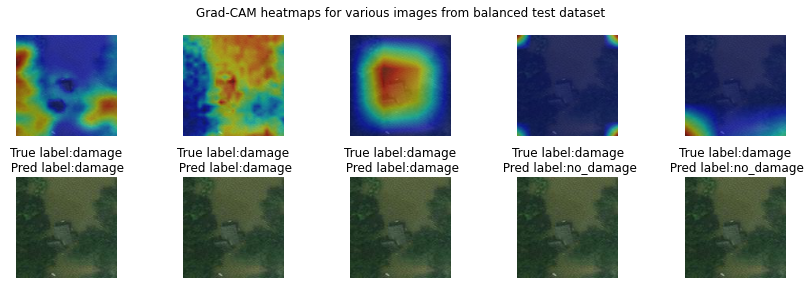

In [116]:
models_list = [model,model_reg,model_resn,model_VGG,model_MobN]

fig,ax = plt.subplots(2,5,figsize=(12, 4))

i=0
for model_ in models_list:
    gradcam = Gradcam(model_,model_modifier=ReplaceToLinear(),clone=True)
    cam = gradcam(score_function(0),img_data[0])

    heatmap = np.uint8(cm.jet(cam)[..., :3] * 255)
    
    ax[1,i].imshow(img_data[0][0])
    img_pred = np.round(model_.predict(img_data[0]).flatten()[0])
    ax[1,i].set_title(f'True label:{img_labels[0]}\n Pred label:{label_dict[img_pred]}')
    ax[1,i].axis('off')

    ax[0,i].imshow(img_data[0][0])
    ax[0,i].imshow(heatmap[0], cmap='jet', alpha=0.5) # overlay
    #ax[0,1].set_title(f'Label:{val_img_labels[i]}')
    ax[0,i].axis('off')
    i=i+1

fig.suptitle('Grad-CAM heatmaps for various images from balanced test dataset')
plt.tight_layout()
plt.show()

**Interpretation:** The heatmaps for different models show how differently each model is learning the patterns from the image. The base, regularized and Resnet models learn correctly and give us correct predictions for this image, whereas VGG19 and Mobilenet learn and predict incorrectly. 

# **Conclusions**
* We can infer that VGG-19, Mobilenet and Inception-V3 models give the best accuracy scores.
* Pretrained weights of ImageNet helped us achieve better classification accuracy test datasets.
* The saliency maps and GradCAM heatmaps captured the features of the images quite accurately in most of the models.


# **Future Scope**
* We can further take more problem-specific data to train the model better and get even better accuracy scores.
* As a matter of future research , we can work on building up more efficient model architecture for predictions comparable to SOTA models.